# Bootstrap multiple comparisons tutorial

This notebook provides a step-by-step guide to using BootComp to perform multiple comparisons of simulation output data

## Preamble

To help with management and house keeping BootComp is split up over a number of Python modules.  We need to import these into the notebook before we can run any analysis.

1. Bootstrap = core bootstrap routines for resampling and calculating test statistics. 
2. BootIO = file input and output functions as well as functions for displaying results on screen
3. BootChartExtensions - MatPlotLib functions for displaying comparions using charts
4. MCC - multiple comparison utility functions e.g. Bonferroni adjustment
5. ConvFuncs - utility module contains functions for converting between datatypes

In [106]:
import Bootstrap as bs
import BootIO as io
import BootChartExtensions as ch
import MCC as mcc
import ConvFuncs as cf

We are also going to make use of a Python Data Science Library called PANDAS and two plotting librairies called Matplotlib and Seaborn.

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 1. Parameters and setup

In [108]:
N_BOOTS = 2000
INPUT_DATA = "data/real_scenarios.csv"

Scenarios need to be in a .csv file.  Each scenario needs to have the same number of replications/batch means.

In [109]:
scenario_data = io.load_scenarios(INPUT_DATA)
N_SCENARIOS = len(scenario_data)
print("Loaded data. {0} scenarios".format(N_SCENARIOS))

Loaded data. 59 scenarios


Before we run the bootstrap we need to setup a BootstrapArguments class.  The arguments class is a a container class that encapsulates all arguments for the bootstrap.  Some of these arguments are simple value based ones e.g. the number of bootstrap resamples and others are complex functions e.g. the test statisic we will calculate on each bootstrap resample.  

The ones we are going to use in this example are:

1. nboot = the number of bootstrap resamples to run.
2. nscenarios = the number of scenarios to compare
3. ncomparisons = the number of simulataneious comparisons 
4. confidence = the the confidence level we will use within any 100%(1-alpha) Confidence interval we contruct
5. point_estimate_func = A function that takes a set of bootstrap samples as parameter and calculates a point estimate.        e.g the mean or standard deviation.  signature = func(data, args).
6. difference_func = a function that calculates the difference between two scenarios (e.g a mean difference). method signature is func(first_scenario_data, second_scenario_data)
7. summary_func = how do you want to summarise the comparisons?  Percentile CIs? Proportion Sj > Si?  Or graphically?  Specifiy a function of signature func(data, args).

For this example we will use a test statistic of the mean difference and the comparison will be the proportion of Sj > Si

In [110]:
args =  bs.BootstrapArguments()

args.nboots = N_BOOTS
args.nscenarios = N_SCENARIOS

args.point_estimate_func = bs.bootstrap_mean
args.difference_func = bs.boot_mean_diff
args.summary_func = bs.proportion_x2_lessthan_x1
#args.summary_func = bs.proportion_x2_greaterthan_x1


## 2. Analysis procedures

### 2.1 Resampling

To generate a dataset containing resampled test statistics for each scenario you need to run the resample_all_scenarios function from the Bootstrap module.  It takes two parameters i.) the scenario data ii.) A BootstrapArguments object.


In [111]:
boot_data = bs.resample_all_scenarios(scenario_data, args)

boot_data is a list of lists.  Each lists contains the resampled point estimates from the simulation experiment/scenario.  To visualise this data we are going to use a PANDAS DataFrame object.  When displayed each column represents a experiment/scenario and each row represents a bootstrap sample.   

In [112]:
help(cf.resamples_to_df)

Help on function resamples_to_df in module ConvFuncs:

resamples_to_df(list_of_lists, nboots)
    Converts a list_of_lists into a dataframe.  
    The list_of_lists represents a set of bootstrap resamples across
    k systems



In [113]:
df_boots = cf.resamples_to_df(boot_data, N_BOOTS)
df_boots.shape

(2000, 59)

In [114]:
df_boots.head(5)

,1,2,3,4,5,6,7,8,9,10,...,50,51,52,53,54,55,56,57,58,59
1,1.062140,3.023593,2.061934,1.688340,1.173526,1.143759,1.114952,0.980796,1.571331,0.809054,...,0.517833,0.142661,0.105624,0.113169,0.078874,10.743415,0.620028,0.093964,0.086420,0.085048
2,0.988889,3.571948,1.842387,1.923320,1.243210,0.684225,0.984637,1.315227,0.848834,0.834431,...,0.548560,0.268862,0.119342,0.086420,0.141974,9.460768,0.352538,0.125514,0.097394,0.058985
3,0.711934,3.451440,2.646571,1.914747,1.224966,1.087517,1.019205,1.370782,1.007270,0.685871,...,0.438820,0.298354,0.105624,0.110425,0.111110,2.261248,0.456790,0.128944,0.137860,0.205761
4,1.507545,3.274897,2.783059,1.880178,1.255556,0.858025,0.832648,0.929356,0.879013,0.873663,...,0.401509,0.211934,0.128258,0.048011,0.059670,6.000892,0.246914,0.184499,0.098765,0.057613
5,0.738409,3.672017,3.263306,1.863786,1.112895,0.923183,0.870371,0.990124,1.181070,1.018930,...,0.366941,0.257202,0.106996,0.090535,0.080932,4.166393,0.454733,0.113855,0.154321,0.053498


### 2.2. Comparing scenarios

Use the compare_scenarios_pairwise function to conduct an all pairwise comparison of the bootstrapped scenarios.  Note this assumes independence across scenarios/systems modelled.

In [115]:
results = bs.compare_scenarios_pairwise(boot_data, args) 

### 2.3. Printing the results of a comparison

There are two options for printing results to the screen.  'Long' and 'Matrix'

In [116]:
io.print_long_format_comparison_results(results)

Scenario 1
Vs. 2: 0.0
Vs. 3: 0.0
Vs. 4: 0.05
Vs. 5: 0.31
Vs. 6: 0.37
Vs. 7: 0.41
Vs. 8: 0.51
Vs. 9: 0.51
Vs. 10: 0.5
Vs. 11: 0.49
Vs. 12: 0.51
Vs. 13: 0.0
Vs. 14: 0.0
Vs. 15: 0.1
Vs. 16: 0.39
Vs. 17: 0.48
Vs. 18: 0.49
Vs. 19: 0.51
Vs. 20: 0.0
Vs. 21: 0.01
Vs. 22: 0.08
Vs. 23: 0.31
Vs. 24: 0.48
Vs. 25: 0.0
Vs. 26: 0.02
Vs. 27: 0.45
Vs. 28: 0.47
Vs. 29: 1.0
Vs. 30: 1.0
Vs. 31: 1.0
Vs. 32: 1.0
Vs. 33: 1.0
Vs. 34: 1.0
Vs. 35: 1.0
Vs. 36: 1.0
Vs. 37: 1.0
Vs. 38: 1.0
Vs. 39: 1.0
Vs. 40: 1.0
Vs. 41: 0.75
Vs. 42: 1.0
Vs. 43: 1.0
Vs. 44: 1.0
Vs. 45: 1.0
Vs. 46: 1.0
Vs. 47: 1.0
Vs. 48: 1.0
Vs. 49: 0.01
Vs. 50: 0.99
Vs. 51: 1.0
Vs. 52: 1.0
Vs. 53: 1.0
Vs. 54: 1.0
Vs. 55: 0.0
Vs. 56: 0.99
Vs. 57: 1.0
Vs. 58: 1.0
Vs. 59: 1.0
Scenario 2
Vs. 3: 0.95
Vs. 4: 1.0
Vs. 5: 1.0
Vs. 6: 1.0
Vs. 7: 1.0
Vs. 8: 1.0
Vs. 9: 1.0
Vs. 10: 1.0
Vs. 11: 1.0
Vs. 12: 1.0
Vs. 13: 0.01
Vs. 14: 0.5
Vs. 15: 0.99
Vs. 16: 1.0
Vs. 17: 1.0
Vs. 18: 1.0
Vs. 19: 1.0
Vs. 20: 0.0
Vs. 21: 0.64
Vs. 22: 0.74
Vs. 23: 1.0
Vs. 24: 1.0
Vs. 2

Matrix format compares the scenarios by row and column.

In [117]:
matrix = io.results_to_matrix(results)

By default, the matrix is diagnoally only half complete (as the 2nd half is is the inverse of the first). To include the missing cells in the comparison table above use the insert_inverse_results function.

In [118]:
io.insert_inverse_results(matrix, args.nscenarios)


To visualise the results it is again handy to convert the matrix to a dataframe.  You can then apply a map to colour code the cells

In [119]:
df = cf.matrix_to_dataframe(matrix, io.scenario_headers(args.nscenarios))
df.style.applymap(io.colour_cells_by_proportion)

### 2.4. Writing results to file

Once the results are in matrix format you can write these to file with a single function.  The file is written to the working directory and is called results_matrix.csv. The results can be opened in Excel (or otherwise).

In [120]:
io.write_results_matrix(matrix, io.scenario_headers(args.nscenarios))

### 2.5 Visual comparisons

In [121]:
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
pt1 = [min(x0,x1), max(y0, y1)]

g.ax_joint.plot([0,0], [0.25, 1.8], ':k') 


If required a visual comparison of scenarios could be conducted. Chart based comparison functions are contained in the BootChartExtensions module.  Here we illustrate plotting the PDF of mean differences.

In [122]:
#args.summary_func= ch.plot_boostrap_samples_pdf
#figs = bs.compare_scenarios_pairwise(boot_data, args) 

Here we illustrate plotting the CDF of mean differences.

In [123]:
#args.summary_func = ch.plot_boostrap_samples_cdf
#bs.compare_scenarios_pairwise(boot_data, args) 

## 2.6 Ranking Systems

### 2.6.1 Rank by Wins

To help identify the top systems found in experimentation use Bootstrap.rank_systems_min and Bootstrap.rank_systems_max.  These return a frequency table reporting the number of proportion of bootstrap resamples where system i was the best (minimum or maximium).  Results exclude systems that never came top.

In [124]:
help(bs.rank_systems_min)

Help on function rank_systems_min in module Bootstrap:

rank_systems_min(df_boots, args)
    Returns a dataframe containing ranked systems.  
    Dataframe contains the frequency and proportion of bootstrap
    resamples where a systems was 'best'.  In this case the minimum value.
    special case of rank_systems_msmallest
    
    @df_boots - Pandas.DataFrame of bootstrap resamples. cols = systems
                rows = resamples
    @args - BootstrapArguments object
    @args.nboots- the number of bootstrap resamples per system



In [125]:
ranks = bs.rank_systems_min(df_boots, args)
s_ranks = ranks.sort_values("f_x", ascending=False)
s_ranks

,f_x,p_x
system,,
48,145,0.0725
47,140,0.0700
40,130,0.0650
38,130,0.0650
46,124,0.0620
39,120,0.0600
29,115,0.0575
54,113,0.0565
36,112,0.0560


In [126]:
df_boots.to_csv('resamples.csv')

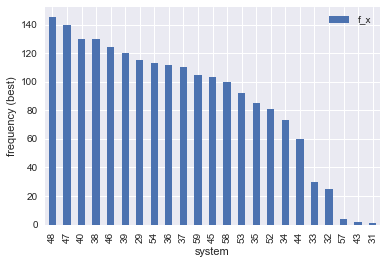

In [127]:
ax= s_ranks.plot(x=ranks.index, y='f_x', kind='bar')
ax.set_ylabel('frequency (best)')
plt.show()

In [128]:
fig = ax.get_figure()
fig.savefig("rank_1.tif", format = 'tif', dpi=200)

### 2.6.2 Top m

Alternatively you can find the proportion of resamples where a system was in the best m systems.
I.e. What were the proportion of 1000 bootstrap resamples where the results for system 1 was in the smallest 5 of all of the systems.  

There are two two functions:
1. Bootstrap.rank_systems_msmallest(DataFrame, BootstrapArguments, m)
2. Bootstrap.rank_systems_mlargest(DataFrame, BootstrapArguments, m)

Note that when m = 1 these functions are equivalent to those introduced in section 2.6.1

For this example the output measure related to waiting times.  We therefore use function 1 above converned with finding systems that consistently rank amoung the lowest 5 waiting times.

In [129]:
help(bs.rank_systems_msmallest)

Help on function rank_systems_msmallest in module Bootstrap:

rank_systems_msmallest(df_boots, args, m)
    Returns a the systems that occur most frequently in 
    the 'm' systems with the smallest values for each resample.  
    
    @df_boots - Pandas.DataFrame of bootstrap resamples. cols = systems
                rows = resamples
    @args - arguments used in the resamples
    @m- number of best systems to consider



In [130]:
msmallest = bs.rank_systems_msmallest(df_boots, args, 5)
msmallest

,f_x,p_x
system,,
38,604,0.3020
54,597,0.2985
29,590,0.2950
40,590,0.2950
46,572,0.2860
47,571,0.2855
48,569,0.2845
39,549,0.2745
45,545,0.2725


In [131]:
s_ranks = msmallest.sort_values("f_x", ascending=False)


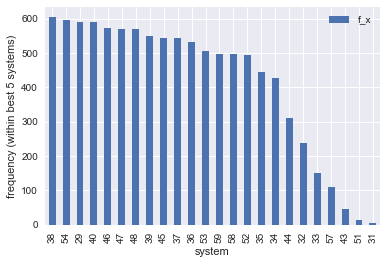

In [132]:
ax= s_ranks.plot(x=s_ranks.index, y='f_x', kind='bar')
ax.set_ylabel('frequency (within best 5 systems)')

plt.show()

In [133]:
fig = ax.get_figure()
fig.savefig("rank_2.tif", format = 'tif', dpi=200)

### 2.6.2 Rerunning comparisons using 'the best' subset of all systems

The ranking analysis from 2.6.1. provides a shortlist of the systems that consistently appear in the best m systems.  This information can be used to perform a comparison of the subset of systems with the most promising outputs.  First we need to do two things:
1.) Get the list of system/scenario ids as a list
2.) Get the subset of bootstrap resamples corresponding to this subset.  

In [134]:
subset_indexes = msmallest.index.values.tolist()
print(subset_indexes)
#zero indexed
subset_indexes_zero = [x - 1 for x in subset_indexes]

subset = cf.subset_of_list(boot_data, subset_indexes_zero)
print(subset[0][0:10])

[38, 54, 29, 40, 46, 47, 48, 39, 45, 37, 36, 53, 59, 58, 52, 35, 34, 44, 32, 33, 57, 43, 51, 31]
[0.14403296095, 0.14471883215, 0.09122087584999998, 0.16255148415, 0.08779151914999998, 0.1042524297, 0.1454047029, 0.07201648065, 0.11934159664999996, 0.13237315019999998]


In [135]:
df_boots[40].head(10)

1     0.063786
2     0.137860
3     0.141975
4     0.062414
5     0.054870
6     0.052812
7     0.089849
8     0.100823
9     0.124143
10    0.099451
Name: 40, dtype: float64

Next we update the BootStrapArguments object: i.e. the number of scenarios we are working with and the type of comparison we want to do. Then run the compare_scenarios_pairwise function

In [136]:
args.nscenarios = len(subset)
args.summary_func = bs.proportion_x2_lessthan_x1
args.summary_func = bs.proportion_x2_greaterthan_x1
results = bs.compare_scenarios_pairwise(subset, args) 
matrix = io.results_to_matrix(results) 
io.insert_inverse_results(matrix, args.nscenarios)

In [137]:
df = cf.matrix_to_dataframe(matrix, [str(i) for i in subset_indexes])
df.style.applymap(io.colour_cells_by_proportion)

To code below limits the comparison to the top 13 ranked systems.

In [138]:
subset_indexes = msmallest.index.values.tolist()[:13]
subset_indexes_zero = [x - 1 for x in subset_indexes]
subset = cf.subset_of_list(boot_data, subset_indexes_zero)
args.nscenarios = len(subset)
args.summary_func = bs.proportion_x2_lessthan_x1
results = bs.compare_scenarios_pairwise(subset, args) 

matrix = io.results_to_matrix(results) 
io.insert_inverse_results(matrix, args.nscenarios)

df = cf.matrix_to_dataframe(matrix, [str(i) for i in subset_indexes])

df.style.applymap(io.colour_cells_by_proportion)


### 2.6.3 Visual Comparisons

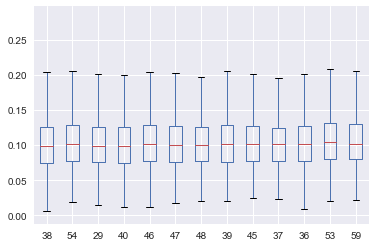

In [139]:
subset_indexes = msmallest.index.values.tolist()[:13]
ax = df_boots[subset_indexes].plot.box()

In [140]:
from statistics import mean
subset = cf.subset_of_list(scenario_data, subset_indexes)
print([mean(i) for i in subset])
print(subset_indexes)

IndexError: list index out of range